In [1]:
import os
os.environ["MUJOCO_GL"] = ""
from datetime import datetime
import random

from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
import minigrid
import gymnasium as gym

from example_load_minigrid_data import transform_obs_to_image
from odgn.env_interaction import collect_data
from odgn.gym_dataset import GymDataset

/Users/oskar/Desktop/temp/offline-dataset-generator/.venv/lib/python3.10/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Datasets can be generated using the `collect_data` function
There environment of different sizes available. A list can be obtained with:

In [2]:
from __future__ import annotations

import numpy as np
import labmaze

from minigrid.core.constants import COLOR_NAMES
from minigrid.core.grid import Grid
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Wall, Ball
from minigrid.minigrid_env import MiniGridEnv


class LabMazePlaygroundEnv(MiniGridEnv):
    """
    MiniGrid environment using LabMaze for maze generation.
    No explicit goal or reward.
    """

    def __init__(self, size = 15, max_steps=100, **kwargs):
        mission_space = MissionSpace(mission_func=self._gen_mission)
        self.size = size + 2  # full MiniGrid size INCLUDING borders
        super().__init__(
            mission_space=mission_space,
            width=self.size,
            height=self.size,
            max_steps=max_steps,
            **kwargs,
        )

    @staticmethod
    def _gen_mission():
        return ""

    def _gen_grid(self, width, height):
        # Create empty MiniGrid grid
        self.grid = Grid(width, height)

        # -------------------------
        # Generate LabMaze layout
        # -------------------------
        # We generate inside the border
        maze_w = width
        maze_h = height

        maze = labmaze.RandomMaze(
            height = height,  # with outer walls
            width = width,
            room_max_size=3,
            objects_per_room=1,
            max_rooms=9,
        )

        # Convert entity layer to numpy array
        # entity_layer is shape (H, W)
        maze_grid = np.array(maze.entity_layer)

        # -------------------------
        # Translate LabMaze → MiniGrid
        # -------------------------
        for y in range(maze_h):
            for x in range(maze_w):
                cell = maze_grid[y, x]

                # Wall symbols vary slightly; these are the common ones
                if cell in ("#", "*"):
                    self.grid.set(x, y, Wall())

        # -------------------------
        # Optional: random objects
        # -------------------------
        for y, x in np.argwhere(maze_grid == 'G'):
            # LabMaze uses (row, col) == (y, x)
            # y, x = obj.position

            # Skip if cell is not empty in MiniGrid
            if self.grid.get(x, y) is not None:
                continue

            color = self._rand_elem(COLOR_NAMES)
            ball = Ball(color)

            self.grid.set(x, y, ball)
    
        # -------------------------
        # Place agent
        # -------------------------
        self.place_agent()

        self.mission = ""

from minigrid import register
register(
    id="LabMaze-Playground-v0",
    entry_point=LabMazePlaygroundEnv,
)

100%|██████████| 10/10 [00:00<00:00, 65.81it/s]


(np.float64(-0.5), np.float64(543.5), np.float64(543.5), np.float64(-0.5))

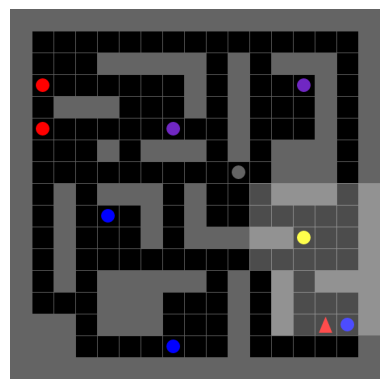

In [3]:
steps = None
episodes = 10
env_id = "LabMaze-Playground-v0"

env = gym.make(env_id, render_mode='rgb_array', size=15)

# policy = lambda obs: (env.action_space.sample(), 0.0)
# instead of sampling from all actions, limit to 0: left, 1: right, 2: forward
# this results in more interesting trajectories for random exploration
policy = lambda obs: (random.choice((0, 1, 2)), 0.0)
trajectories = collect_data(env, policy, n_episodes=10)
dataset = GymDataset(env_id, datetime.now() ,trajectories)
env.reset()
plt.imshow(env.render())
plt.axis('off')

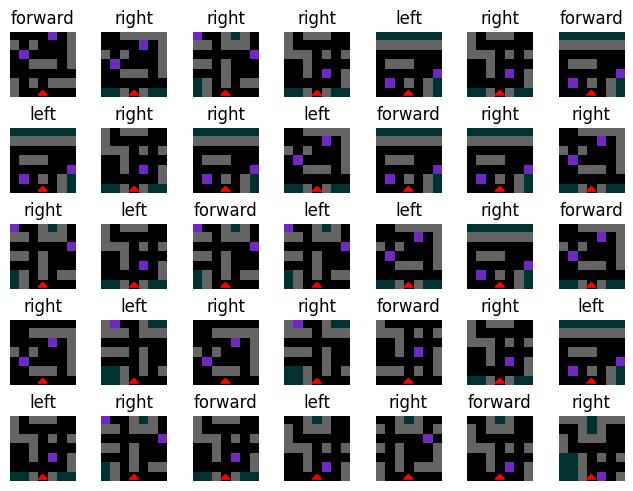

In [4]:
traj = 0
fig, axs = plt.subplots(5, 7, layout='constrained')
for i, ax in enumerate(axs.flat):

    img = transform_obs_to_image(dataset[traj].o[i])
    ax.imshow(img)
    ax.axis('off')
    action = minigrid.core.actions.Actions(dataset[traj].a[i])
    # facing = '↓←↑→'[dataset[traj].o[i]['direction']]

    triangle = [ (2.5, 6.3), (3.5, 6.3), (3, 5.8)]
    poly = Polygon(triangle, closed=True, color='red')
    ax.add_patch(poly)
    ax.set_title(f'{action.name}')

The agent sees 7x7 viewport. Because the viewport is not centered on the agent, there is little overlap after turning left or right.

Goal is to predict `(internal EGRU state, observation, action) => (next observation)`